In [3]:
import numpy as np
import pandas as pd
import os
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random
from tensorflow.keras.models import Model
import seaborn as sns

In [ ]:

import matplotlib.image as img
import itertools
import pathlib
import warnings
import time
import gc
from IPython.display import Markdown, display
from PIL import Image

warnings.filterwarnings('ignore')

In [4]:
def load_images_from_folder(folder, only_path=False, label=None):
    images = []
    if only_path:
        if os.path.isfile(folder):
            return [(label, folder)]  # Return the single image path with its corresponding label
    else:
        path = []
        for filename in os.listdir(folder):
            img_path = os.path.join(folder, filename)
            if os.path.isfile(img_path):  # Check if the path is a file
                if only_path:
                    path.append(img_path)
                else:
                    images.append((label, img_path))
        if only_path:
            return path  # Return the list of image paths
    return images  # Return the list of image labels and paths

# Specify the directory path
dirp = "/kaggle/input/mst-dataset/mst_data/"

# Load images from folders and create a list of (label, path) tuples
images = []
for f in os.listdir(dirp):
    if os.path.isdir(dirp + f):
        for d in os.listdir(dirp + f):
            images += load_images_from_folder(os.path.join(dirp, f, d), True, label=f)

# Create a DataFrame from the list of tuples
df = pd.DataFrame(images, columns=["skintones", "path"])

# Shuffle the DataFrame if desired
df = df.sample(frac=1).reset_index(drop=True)
print(df)

     skintones                                               path
0      Class_9  /kaggle/input/mst-dataset/mst_data/Class_9/PXL...
1      Class_5  /kaggle/input/mst-dataset/mst_data/Class_5/PXL...
2      Class_1  /kaggle/input/mst-dataset/mst_data/Class_1/PXL...
3      Class_9  /kaggle/input/mst-dataset/mst_data/Class_9/PXL...
4      Class_6  /kaggle/input/mst-dataset/mst_data/Class_6/PXL...
...        ...                                                ...
1376   Class_1  /kaggle/input/mst-dataset/mst_data/Class_1/PXL...
1377   Class_9  /kaggle/input/mst-dataset/mst_data/Class_9/PXL...
1378   Class_6  /kaggle/input/mst-dataset/mst_data/Class_6/PXL...
1379   Class_5  /kaggle/input/mst-dataset/mst_data/Class_5/PXL...
1380   Class_9  /kaggle/input/mst-dataset/mst_data/Class_9/PXL...

[1381 rows x 2 columns]


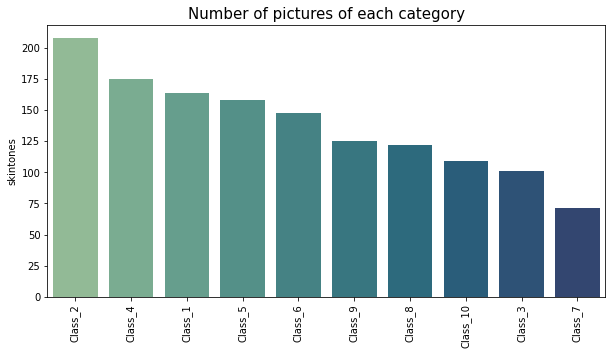

In [5]:
import seaborn as sns
fc = df["skintones"].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(x = fc.index, y = fc, palette = "crest")
plt.title("Number of pictures of each category", fontsize = 15)
plt.xticks(rotation=90)
plt.show()

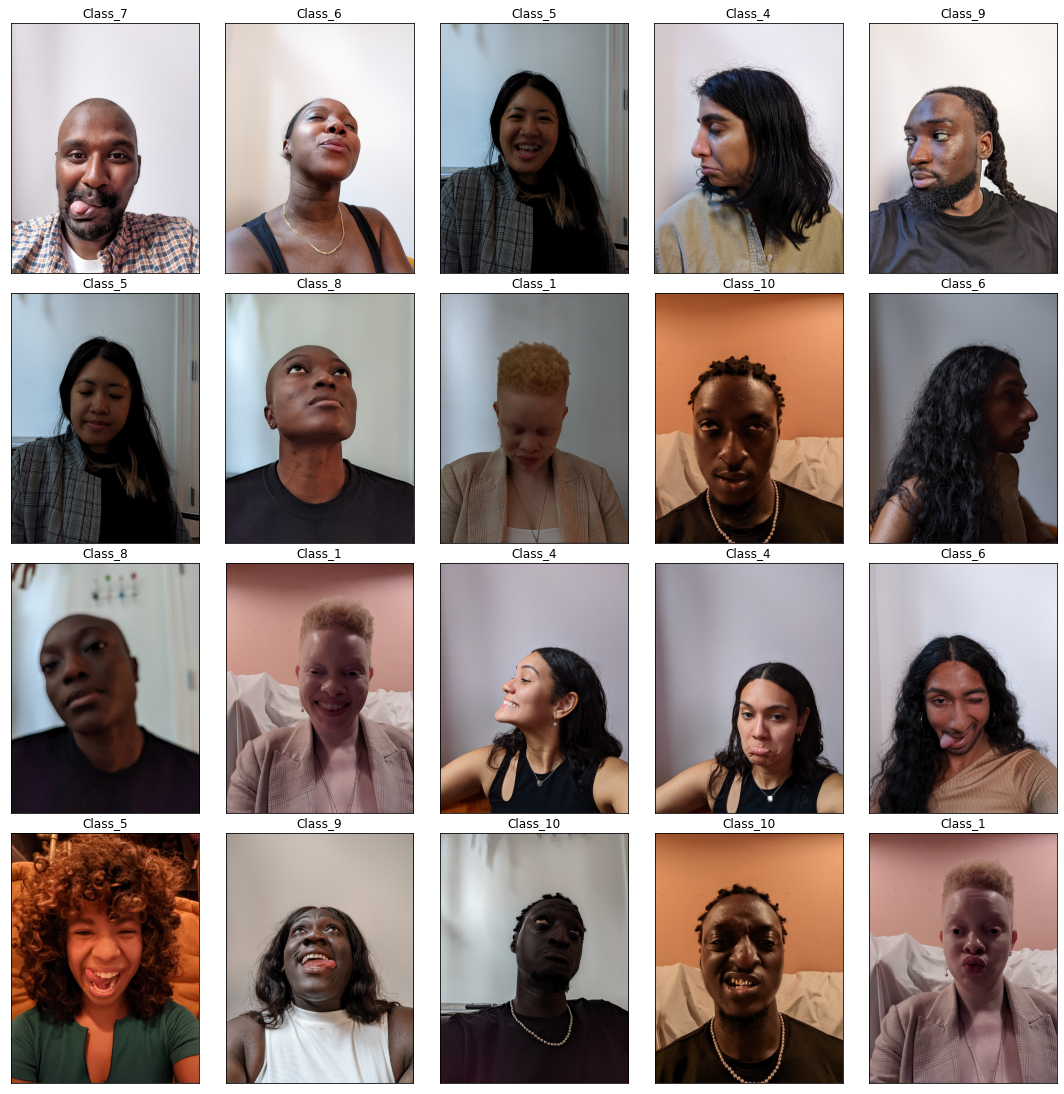

In [6]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.path[i+20]))
    ax.set_title(df.skintones[i+20], fontsize = 12)
plt.tight_layout(pad=0.0)
plt.show()

In [8]:
def extractSkin(image):
  # Taking a copy of the image
  img =  image.copy()
  # Converting from BGR Colours Space to HSV
  img =  cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
  
  # Defining HSV Threadholds
  lower_threshold = np.array([0, 48, 80], dtype=np.uint8)
  upper_threshold = np.array([20, 255, 255], dtype=np.uint8)
  
  # Single Channel mask,denoting presence of colours in the about threshold
  skinMask = cv2.inRange(img,lower_threshold,upper_threshold)
  
  # Cleaning up mask using Gaussian Filter
  skinMask = cv2.GaussianBlur(skinMask,(3,3),0)
  
  # Extracting skin from the threshold mask
  skin  =  cv2.bitwise_and(img,img,mask=skinMask)
  
  # Return the Skin image
  return cv2.cvtColor(skin,cv2.COLOR_HSV2BGR)

In [9]:
# Load and preprocess images
images = []
for image_path in df["path"]:
    image = plt.imread(image_path)
    image = cv2.resize(image, (224, 224))
    image = extractSkin(image)
    image_array = img_to_array(image)
    image_array = image_array / 255.0  # Normalize pixel values
    images.append(image_array)
X = np.array(images)

In [10]:
# Convert labels to categorical values
y = pd.get_dummies(df["skintones"]).values
print(y)

[[0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]]


In [11]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
pretrained_model3 = tf.keras.applications.DenseNet201(input_shape=(224,224,3),include_top=False,weights='imagenet',pooling='avg')
pretrained_model3.trainable = False

74842112/74836368 [==============================] - 4s 0us/step


In [13]:
inputs3 = pretrained_model3.input
x3 = tf.keras.layers.Dense(128, activation='relu')(pretrained_model3.output)
outputs3 = tf.keras.layers.Dense(10, activation='softmax')(x3)
model = tf.keras.Model(inputs=inputs3, outputs=outputs3)

In [14]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [15]:
# Melatih model
model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
35/35 [==============================] - 25s 249ms/step - loss: 1.9262 - accuracy: 0.3435 - val_loss: 1.5525 - val_accuracy: 0.3827
Epoch 2/100
35/35 [==============================] - 4s 110ms/step - loss: 1.3256 - accuracy: 0.5344 - val_loss: 1.3352 - val_accuracy: 0.4838
Epoch 3/100
35/35 [==============================] - 4s 111ms/step - loss: 1.1026 - accuracy: 0.5984 - val_loss: 1.2699 - val_accuracy: 0.5921
Epoch 4/100
35/35 [==============================] - 4s 109ms/step - loss: 1.0130 - accuracy: 0.6439 - val_loss: 1.1999 - val_accuracy: 0.5560
Epoch 5/100
35/35 [==============================] - 4s 108ms/step - loss: 0.9754 - accuracy: 0.6578 - val_loss: 1.1472 - val_accuracy: 0.5957
Epoch 6/100
35/35 [==============================] - 4s 109ms/step - loss: 0.8947 - accuracy: 0.6914 - val_loss: 1.1470 - val_accuracy: 0.6209
Epoch 7/100
35/35 [==============================] - 4s 110ms/step - loss: 0.8757 - accuracy: 0.6950 - val_loss: 1.0856 - val_accuracy: 0.631

In [16]:
# Make predictions on the testing data
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5992779783393501


In [17]:
his=model.fit(datagen.flow(trainx,trainy,batch_size=32),validation_data=(testx,testy),epochs=100)

NameError: name 'datagen' is not defined

In [ ]:
y_pred=model.predict(testx)
pred=np.argmax(y_pred,axis=1)
ground = np.argmax(testy,axis=1)
print(classification_report(ground,pred))

In [ ]:
get_acc = his.history['accuracy']
value_acc = his.history['val_accuracy']
get_loss = his.history['loss']
validation_loss = his.history['val_loss']

epochs = range(len(get_acc))
plt.plot(epochs, get_acc, 'r', label='Accuracy of Training data')
plt.plot(epochs, value_acc, 'b', label='Accuracy of Validation data')
plt.title('Training vs validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

In [ ]:
epochs = range(len(get_loss))
plt.plot(epochs, get_loss, 'r', label='Loss of Training data')
plt.plot(epochs, validation_loss, 'b', label='Loss of Validation data')
plt.title('Training vs validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [ ]:
pred2=model.predict(testX)
print(pred2.shape)

PRED=[]
for item in pred2:
    value2=np.argmax(item)      
    PRED+=[value2]
print(pd.Series(PRED).value_counts())

In [ ]:
ANS=testY0
accuracy=accuracy_score(ANS,PRED)
print(accuracy)

In [ ]:
m=len(testX)
M=list(range(m))
random.seed(2021)
random.shuffle(M)

In [ ]:
fig, axs = plt.subplots(3,3,figsize=(12,12))
for i in range(9):
    r=i//3
    c=i%3
    img1 = testX[M[i]]
    ax=axs[r][c].axis("off")
    actual=reverse_mapping[testY0[M[i]]]
    predict=reverse_mapping[PRED[M[i]]]    
    ax=axs[r][c].set_title(actual+'=='+predict)
    ax=axs[r][c].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.show()

# CNN model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define the number of classes
num_classes = 5

# Create the model
model1 = Sequential()
# Add convolutional layers
model1.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model1.add(MaxPooling2D((2, 2)))
model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPooling2D((2, 2)))
model1.add(Conv2D(128, (3, 3), activation='relu'))
model1.add(MaxPooling2D((2, 2)))


# Add flatten layer
model1.add(Flatten())

# Add fully connected layers
model1.add(Dense(128, activation='relu'))

# Add output layer
model1.add(Dense(num_classes, activation='softmax'))


In [ ]:
model1.summary()

In [ ]:
model1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
cnnModel=model1.fit(datagen.flow(trainx,trainy,batch_size=32),validation_data=(testx,testy),epochs=100)

In [ ]:
y_pred=model.predict(testx)
pred=np.argmax(y_pred,axis=1)
ground = np.argmax(testy,axis=1)
print(classification_report(ground,pred))

In [ ]:
pred2=model.predict(testX)
print(pred2.shape)

PRED=[]
for item in pred2:
    value2=np.argmax(item)      
    PRED+=[value2]
print(pd.Series(PRED).value_counts())

In [ ]:
ANS=testY0
accuracy=accuracy_score(ANS,PRED)
print(accuracy)

In [ ]:
m=len(testX)
M=list(range(m))
random.seed(2021)
random.shuffle(M)

In [ ]:
fig, axs = plt.subplots(3,3,figsize=(12,12))
for i in range(9):
    r=i//3
    c=i%3
    img1 = testX[M[i]]
    ax=axs[r][c].axis("off")
    actual=reverse_mapping[testY0[M[i]]]
    predict=reverse_mapping[PRED[M[i]]]    
    ax=axs[r][c].set_title(actual+'=='+predict)
    ax=axs[r][c].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.show()